# 用新版特徵做訓練

In [102]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot

a = '改掉SOH定義的資料集_noerror.csv'
data = np.genfromtxt(a, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')
[Row,Column] = data.shape
print(data[0:2,:])

[[ 5.9916668e+01  2.2200000e+03 -2.3300000e-01  1.1700000e+03
   8.0069000e+00  1.5000000e+03  8.7500000e+00]
 [ 6.0583336e+01  2.2200000e+03 -2.1400000e-01  1.2300000e+03
   7.9929000e+00  1.7100000e+03  8.6700000e+00]]


In [ ]:
features_train2, features_test2, soh_train2, soh_test2 = train_test_split(data[:,1:7], data[:,0:1], test_size=0.2, random_state=100)
print("features_train\n", features_train2)
print("soh_train\n", soh_train2)     #檢查格式是否正確,才不會讓ML程式垮掉

# BRR

In [57]:
from sklearn import linear_model     # BayesianRidge
import time
t1 = time.monotonic()

params_Baye = {"n_iter":700 , "tol":0.01, "alpha_1":1e-04, "alpha_2":1e-06, "lambda_1":1e-06, "lambda_2":1e-06}   # ,"n_iter":100 , "tol":0.01, "alpha_2":1e-06, "lambda_1":1e-06, "lambda_2":1e-06
model = linear_model.BayesianRidge(tol=0.0001, fit_intercept=True, compute_score=True)   # 
model.set_params(**params_Baye)
model.fit(features_train2, soh_train2)
prediction = model.predict(features_test2)
RMSE = np.round(math.sqrt(mean_squared_error(soh_test2, prediction)),3)
MAE = np.round(mean_absolute_error(soh_test2, prediction),3)
R_sq = np.round(r2_score(soh_test2, prediction),3)
Residual = prediction-soh_test2
print("Residual", Residual)

t2 = time.monotonic()
print("time elapsed:" + str(np.round(t2-t1,3)) + " seconds")

Residual [ 1.59499141  2.05002834  1.0768205  ...  2.5359474  -0.27964725
  0.99429978]
time elapsed:0.016 seconds


low_ci_bound
 [28.42285318 29.96122211 41.43245827 ... 22.19714118 48.52043352
 38.48882755]
high_ci_bound
 [35.93379764 37.47216656 48.94340272 ... 29.70808563 56.03137798
 45.99977201]
std of the SOH
  =  0.146


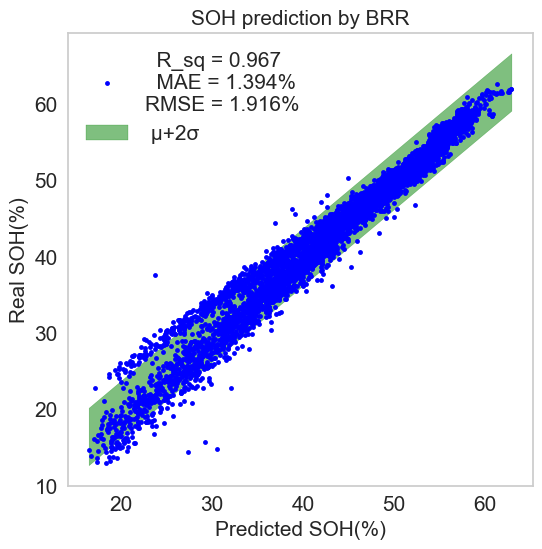

In [60]:
'''加信賴區間後的圖'''
import seaborn as sns
import matplotlib
import scipy.stats as st
matplotlib.rcParams.update({'font.size': 15})

# predicted expect and calculte confidence interval
low_ci_bound, high_ci_bound = st.t.interval(0.95, len(prediction),
                                           loc=prediction,scale=Residual.std())
print("low_ci_bound\n", low_ci_bound)
print("high_ci_bound\n", high_ci_bound)
print("std of the SOH\n  = ", np.round(st.sem(prediction),3))

# plot confidence interval
plt.figure(figsize=(6,6), dpi = 100)   #
plt.plot(prediction,soh_test2, color='blue', linestyle='None' , marker='.', label=f'  R_sq = {R_sq}\n  MAE = {MAE}%\nRMSE = {RMSE}%')
plt.fill_between(sorted(prediction), sorted(low_ci_bound), sorted(high_ci_bound), color='green', alpha=0.5,
                label=' μ+2σ')   #  ' μ+2σ', color='blue', linestyle='None' , marker='.'
plt.xlabel("Predicted SOH(%)", fontsize=15) 
plt.ylabel("Real SOH(%)", fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.title("SOH prediction by BRR", fontsize=15)   #_No relaxation
plt.grid()
plt.show()

Sampling Mean: 0.026
Sampling StdErr: 1.916
95% Confidence Interval: [-3.728  3.781]


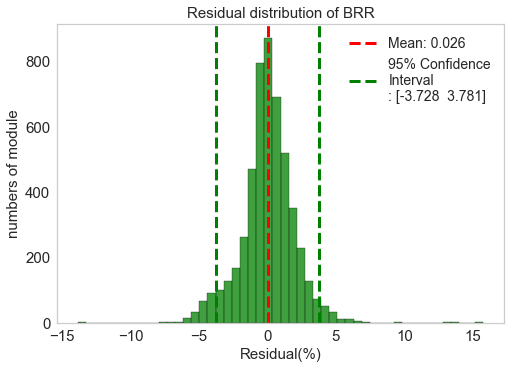

In [62]:
'''Residuals'''
from scipy import stats

# 取得 X_mean 的 mean, std, 95% 信賴區間
m = Residual.mean()                  # X_bar 的平均
se = Residual.std()                  # 標準誤
ci = np.round(stats.norm.interval(0.95, m, se),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m:.3f}')
print (f'Sampling StdErr: {se:.3f}')
print (f'95% Confidence Interval: {ci}')

sns.histplot(Residual, color='green', bins=50, kde=False)
plt.axvline(m, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m:.3f}')
plt.axvline(ci[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci}')
plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Residual(%)', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Residual distribution of BRR', fontsize=15)   #_No relaxation
plt.legend(fontsize=14); plt.grid(); plt.show()

Sampling Mean: 0.006
Sampling StdErr: 0.069
95% Confidence Interval: [-0.129  0.141]


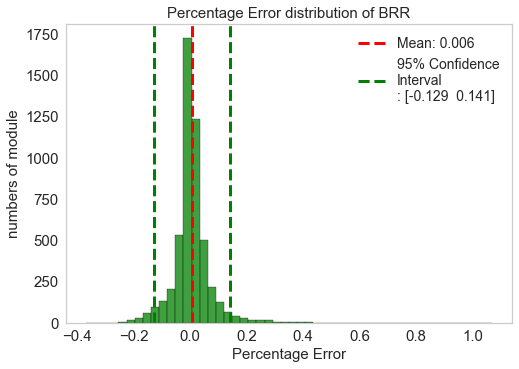

In [63]:
'''Percentage Error'''
pep_brr = Residual/soh_test2

# 取得 X_mean 的 mean, std, 95% 信賴區間
m1 = pep_brr.mean()                  # X_bar 的平均
se1 = pep_brr.std()                  # 標準誤
ci1 = np.round(stats.norm.interval(0.95, m1, se1),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m1:.3f}')
print (f'Sampling StdErr: {se1:.3f}')
print (f'95% Confidence Interval: {ci1}')

sns.histplot(pep_brr, color='green', bins=50, kde=False)
plt.axvline(m1, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m1:.3f}')
plt.axvline(ci1[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci1}')
plt.axvline(ci1[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Percentage Error', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Percentage Error distribution of BRR', fontsize=15)   #_No relaxation
plt.legend(fontsize=14); plt.grid(); plt.show()

In [64]:
file_BRR = np.asarray([soh_test2,prediction,Residual]).T
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0327改soh後ML模型&結果\1_BRR預測結果.csv',file_BRR,fmt='%s',delimiter=',')
print("BRR", file_BRR)   #_No relaxation

BRR [[30.583334   32.17832541  1.59499141]
 [31.666666   33.71669434  2.05002834]
 [44.11111    45.1879305   1.0768205 ]
 ...
 [23.416666   25.9526134   2.5359474 ]
 [52.555553   52.27590575 -0.27964725]
 [41.25       42.24429978  0.99429978]]


RMSE =  3.311
 MAE =  2.417


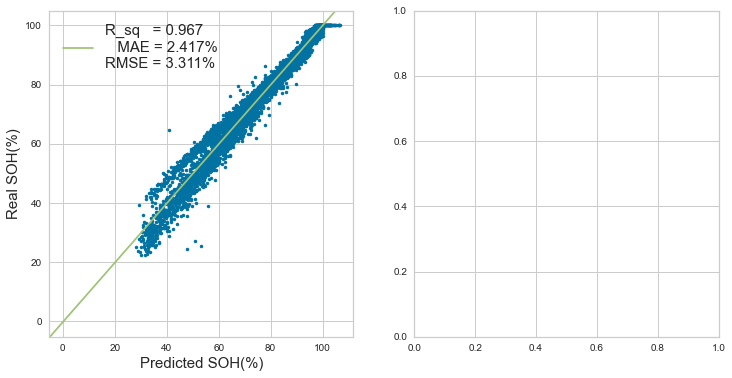

In [172]:
'''無信賴區間的圖(原始)'''
f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(prediction,soh_test2, 'b.')
m1, b1 = np.polyfit(prediction,soh_test2, 1);
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'R_sq   = {R_sq}\n   MAE = {MAE}%\nRMSE = {RMSE}%') # 
ax1.set_xlabel("Predicted SOH(%)", fontsize=15) 
ax1.set_ylabel("Real SOH(%)", fontsize=15)
ax1.legend(fontsize=15)

'''ax2.plot(variable, rmseoos)
ax2.set_xlabel("Iteration", fontsize=18) 
ax2.set_ylabel("RMSE(%)", fontsize=18)'''

print("RMSE = ",RMSE); print(" MAE = ",MAE);

# RF

In [110]:
import time
t1 = time.monotonic()

rmseoos = []
ntreelist = range(900, 950, 50)
for itrees in ntreelist:
    depth = None
    maxft = 3
    model = ensemble.RandomForestRegressor(n_estimators=itrees, max_depth=depth, max_features=maxft, oob_score=False, random_state=100)
    model.fit(features_train2, soh_train2)
    predictions = model.predict(features_test2)
    rmseoos.append(math.sqrt(mean_squared_error(soh_test2, predictions)))
R_sq = np.round(model.fit(features_train2, soh_train2).score(features_test2, soh_test2),3)
MAE = np.round(mean_absolute_error(predictions,soh_test2),3)
RMSE = np.round(np.sqrt(mean_squared_error(predictions,soh_test2)),3)
Residuals = predictions-soh_test2
print("Residuals = ", Residuals)    #print("Best RMSE(%) = ", min(rmseoos))

t2 = time.monotonic()
print("time elapsed: " + str(np.round(t2-t1,3)) + " seconds")

Residuals =  [ 0.37117191  1.92518607  1.49450801 ... -0.60919665 -0.19262096
  1.76817874]
time elapsed: 65.516 seconds


low_ci_bound
 [28.36807209 31.00541824 43.01918419 ... 20.22103552 49.77649822
 40.43174491]
high_ci_bound
 [33.54093973 36.17828589 48.19205184 ... 25.39390317 54.94936587
 45.60461256]
std of the SOH
  =  0.147


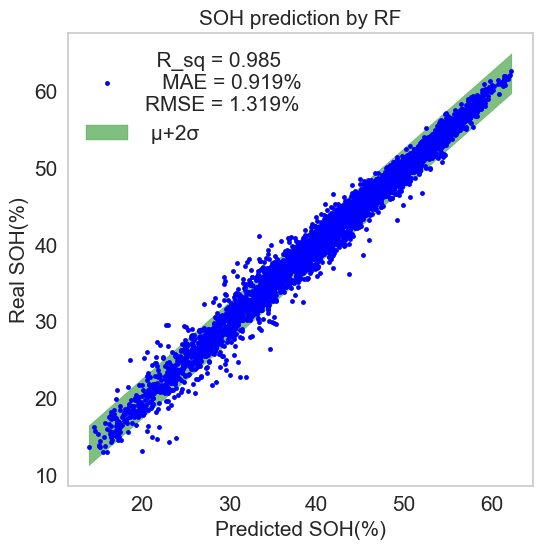

In [112]:
'''加信賴區間後的圖'''
import seaborn as sns
import matplotlib
import scipy.stats as st
matplotlib.rcParams.update({'font.size': 15})

# predicted expect and calculte confidence interval
low_ci_bound, high_ci_bound = st.t.interval(0.95, len(predictions),
                                           loc=predictions,scale=Residuals.std())
print("low_ci_bound\n", low_ci_bound)
print("high_ci_bound\n", high_ci_bound)
print("std of the SOH\n  = ", np.round(st.sem(predictions),3))

# plot confidence interval
plt.figure(figsize=(6,6),dpi=100)
plt.plot(predictions,soh_test2, color='blue', linestyle='None' , marker='.', label=f'  R_sq = {R_sq}\n   MAE = {MAE}%\nRMSE = {RMSE}%')
plt.fill_between(sorted(predictions), sorted(low_ci_bound), sorted(high_ci_bound),
                 color='green', alpha=0.5, label=' μ+2σ')
plt.tick_params(labelsize=15)
plt.xlabel("Predicted SOH(%)", fontsize=15) #15
plt.ylabel("Real SOH(%)", fontsize=15)
plt.legend(fontsize=15)
plt.title("SOH prediction by RF", fontsize=15)   #_No relaxation
plt.grid()
plt.show()

Sampling Mean: 0.001
Sampling StdErr: 1.319
95% Confidence Interval: [-2.585  2.587]


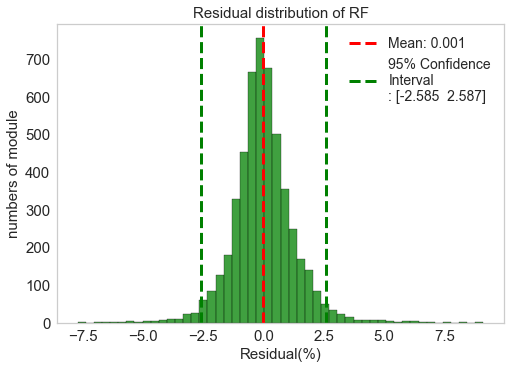

In [113]:
'''Residuals'''
from scipy import stats

# 取得 X_mean 的 mean, std, 95% 信賴區間
m = Residuals.mean()                  # X_bar 的平均
se = Residuals.std()                  # 標準誤
ci = np.round(stats.norm.interval(0.95, m, se),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m:.3f}')
print (f'Sampling StdErr: {se:.3f}')
print (f'95% Confidence Interval: {ci}')

sns.histplot(Residuals, color='green', bins=50, kde=False)
plt.axvline(m, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m:.3f}')
plt.axvline(ci[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci}')
plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Residual(%)', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Residual distribution of RF', fontsize=15)   #_No relaxation
plt.legend(fontsize=14); plt.grid(); plt.show()

Sampling Mean: 0.002
Sampling StdErr: 0.044
95% Confidence Interval: [-0.084  0.089]


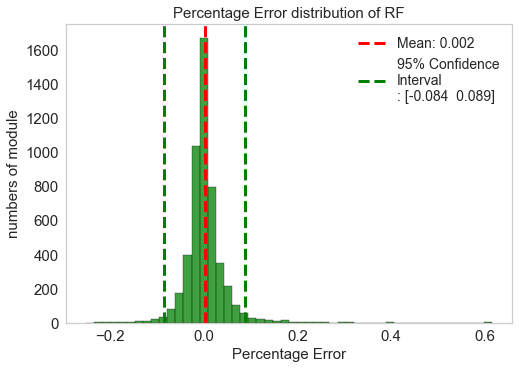

In [114]:
'''Percentage Error'''
pep_rf = Residuals/soh_test2

# 取得 X_mean 的 mean, std, 95% 信賴區間
m2 = pep_rf.mean()                  # X_bar 的平均
se2 = pep_rf.std()                  # 標準誤
ci2 = np.round(stats.norm.interval(0.95, m2, se2),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m2:.3f}')
print (f'Sampling StdErr: {se2:.3f}')
print (f'95% Confidence Interval: {ci2}')

sns.histplot(pep_rf, color='green', bins=50, kde=False)
plt.axvline(m2, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m2:.3f}')
plt.axvline(ci2[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci2}')
plt.axvline(ci2[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Percentage Error', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Percentage Error distribution of RF', fontsize=15)   #_No relaxation
plt.legend(fontsize=14); plt.grid(); plt.show()

In [115]:
file_RF = np.asarray([soh_test2,predictions,Residuals]).T
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0327改soh後ML模型&結果\2_RF預測結果.csv',file_RF,fmt='%s',delimiter=',')
print("FNN", file_RF)   #_No relaxation

FNN [[30.583334   30.95450591  0.37117191]
 [31.666666   33.59185207  1.92518607]
 [44.11111    45.60561801  1.49450801]
 ...
 [23.416666   22.80746935 -0.60919665]
 [52.555553   52.36293204 -0.19262096]
 [41.25       43.01817874  1.76817874]]


C:\Users\Chun-Po\miniconda3\envs\env_pytorch\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


Text(0, 0.5, 'RMSE(%)')

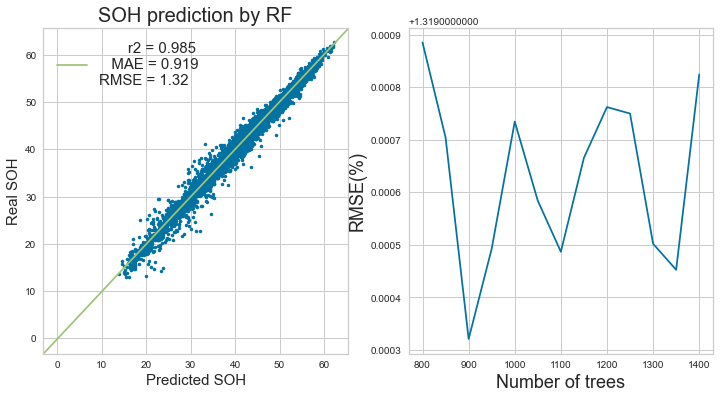

In [109]:
'''無信賴區間的圖(原始)'''
f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(predictions,soh_test2, 'b.')
ax1.set_title("SOH prediction by RF", fontsize=20);
m1, b1 = np.polyfit(predictions,soh_test2.astype(np.float), 1)
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'       r2 = {R_sq}\n   MAE = {MAE}\nRMSE = {RMSE}') # 
ax1.set_xlabel("Predicted SOH", fontsize=15) 
ax1.set_ylabel("Real SOH", fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(ntreelist, rmseoos)
ax2.set_xlabel("Number of trees", fontsize=18) # max features at each nodes
ax2.set_ylabel("RMSE(%)", fontsize=18)


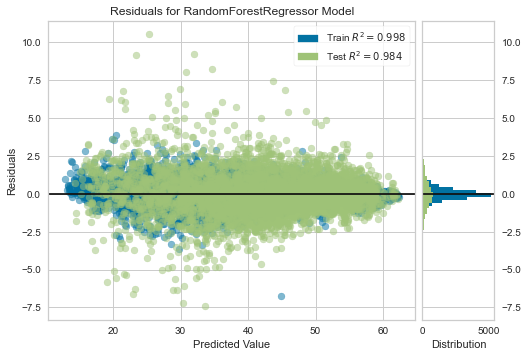

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [42]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model.fit(features_train2, soh_train2),train_alpha=0.5, test_alpha=0.5)
visualizer.fit(features_train2, soh_train2)
visualizer.score(features_test2, soh_test2)
visualizer.poof()

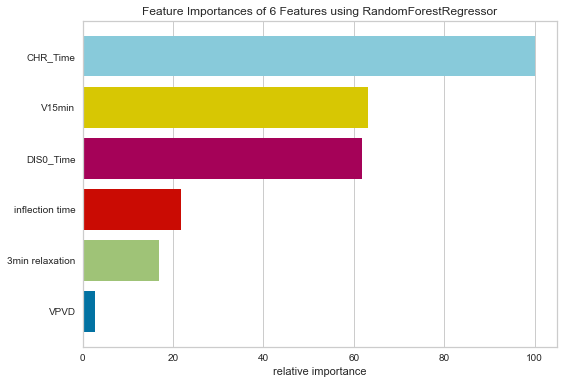

<AxesSubplot:title={'center':'Feature Importances of 6 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [46]:
from yellowbrick.model_selection import FeatureImportances
visualizer = FeatureImportances(model,labels=["CHR_Time","3min relaxation","inflection time","V15min","DIS0_Time","VPVD"])
visualizer.fit(features_train2, soh_train2)     #, dpi=100
visualizer.show()

# 紀錄RF成果

In [ ]:
1228.2052(填紀錄時間)
RMSE(%) =  2.275
time elapsed:13.969 seconds

1228.2048(填紀錄時間)
RMSE(%) =  2.294
time elapsed:54.672 seconds
    
1228.2044(填紀錄時間)
RMSE(%) =  2.299
time elapsed:619.265 seconds

# FNN

In [116]:
import torch
from torch import nn, optim
from IPython import display
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp

scaler = pp.MinMaxScaler().fit(data[:,[1,2,3,4,5,6]])     # 默認數據壓縮范圍為[0,1]1,
data_var = scaler.transform(data[:,[1,2,3,4,5,6]])
data_SOH = data[:,0:1]
data_all = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據1,
print("data_all\n", data_all[0])

data_all
 [59.916668    1.          0.8322884   0.55167532  0.07867325  0.56570997
  0.50806452]


In [249]:
features_train, features_test, soh_train, soh_test = train_test_split(data_all[:,[1,2,3,4,5]], data_all[:,0:1], test_size=0.2, random_state=100)
print("features_train\n", features_train)
print("soh_train\n", soh_train)     #檢查格式是否正確,才不會讓ML程式垮掉

features_train
 [[0.79485238 0.78683386 0.34308636 0.1493284  0.4939577 ]
 [0.2990159  0.68652038 0.08400189 0.60396107 0.26397281]
 [0.58289175 0.69592476 0.32137801 0.24520285 0.4070997 ]
 ...
 [0.99242998 0.86833856 0.3827277  0.12739857 0.56570997]
 [0.42240727 0.72884013 0.1160925  0.40241228 0.33987915]
 [0.66464799 0.80721003 0.32751298 0.19647752 0.39577039]]
soh_train
 [[49.77778 ]
 [24.777777]
 [42.416668]
 ...
 [56.02778 ]
 [32.38889 ]
 [44.36111 ]]


In [242]:
'''Original'''
import time
t1 = time.monotonic()
starttime = time.ctime();
starttime = starttime.split()

X_train = torch.from_numpy(features_train.astype(np.float64))
y_train = torch.from_numpy(soh_train.astype(np.float64))
X_test = torch.from_numpy(features_test.astype(np.float64))
y_test = torch.from_numpy(soh_test.astype(np.float64))

D = 5  # dimensions
C = 1  # num_classes
H1 = 50  # num_hidden_units_1
H2 = 10  # num_hidden_units_2

learning_rate = 3e-2
lambda_l2 = 1e-4
n_networks = 1     # Number of networks
criterion = torch.nn.MSELoss()     # nn package also has different loss functions. We use MSE for a regression task
totalerr_train = []; totalerr_test = []; total_corr = [];
train_set = []; test_set = []; eveloss = [];
models = list(); y_pretrain = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 0
torch.manual_seed(seed)     #固定random states

for mod in range(n_networks):
    model = nn.Sequential(
        nn.Linear(D, H1),
        nn.ReLU(), 
        nn.Linear(H1, H2),
        nn.ReLU(),
        nn.Linear(H2, C),
    )
    model.to(device)
  # Append models
    models.append(model)
  # Use the optim package to apply ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)     # built-in L2
    #learning_rate = optim.lr_scheduler.StepLR(optimizer, 20000, 0.2, last_epoch=-1)
    for t in range(50000):
      # Feed forward to get the logits     # print("test_set = ", test_set);     # 檢查是否正確取樣
        y_pred = model(X_train.float())
        if t == 0:
            y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
        loss = torch.sqrt(criterion(y_pred.float(), y_train.float()))
        eveloss.append(np.round(loss.item(),6))
        print("start time: ", starttime[1:4])
        print(f"[EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
      # zero the gradients before running
      # the backward pass.
        optimizer.zero_grad()
      # Backward pass to compute the gradient of loss w.r.t our learnable params. 
        loss.backward()
      # Update params
        optimizer.step()
        #learning_rate.step()
        if t == 49999:
            totalerr_train.append(np.round(loss.item(),6))  
          ## Testing
            y_test_pred = model(X_test.float())
          # Compute the loss and accuracy
            loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
            y_test_array = []; y_test_pred_array = [];
            for ii in range(len(y_test)):
                y_test_array.append(y_test.detach().numpy()[ii][0].astype(np.float64))     # [ii]後面有時候要加[0]有時不用,使用時請注意資料集種類
                y_test_pred_array.append(y_test_pred.detach().numpy()[ii][0].astype(np.float64))
            R_sq = np.round(r2_score(y_test_pred_array, y_test_array),3)
            MAE = np.round(mean_absolute_error(y_test_pred_array, y_test_array),3)
            RMSE = np.round(np.sqrt(mean_squared_error(y_test_pred_array,y_test_array)),3)
            Residualss = np.array(y_test_pred_array)-np.array(y_test_array)
            totalerr_test.append(np.round(loss_test.item(),6))
            total_corr.append(np.round(R_sq,3))

print("MAE(%)= ", MAE)
t2 = time.monotonic()
print("start time: ", starttime[1:4])
print("time elapsed:" + str(np.round(t2-t1,3)) + " seconds")

MAE(%)=  1.045
start time:  ['Mar', '29', '09:56:32']
time elapsed:1277.234 seconds


In [243]:
import pickle
with open(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0328檢驗feature影響力\FNN_06.pickle', 'wb') as f:
    pickle.dump(model, f)

In [244]:
with open(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0328檢驗feature影響力\FNN_06.pickle', 'rb') as f:
    model_fnn = pickle.load(f)
    pred=model_fnn(X_test.float())
    print(pred)

tensor([[31.3423],
        [33.6224],
        [45.4334],
        ...,
        [22.8819],
        [52.3046],
        [41.9763]], grad_fn=<AddmmBackward0>)


low_ci_bound
 [28.57531572 30.85543656 42.66647554 ... 20.11495805 49.53763414
 39.20933366]
high_ci_bound
 [34.1092546  36.38937545 48.20041442 ... 25.64889693 55.07157302
 44.74327254]
std of the SOH
  =  0.147


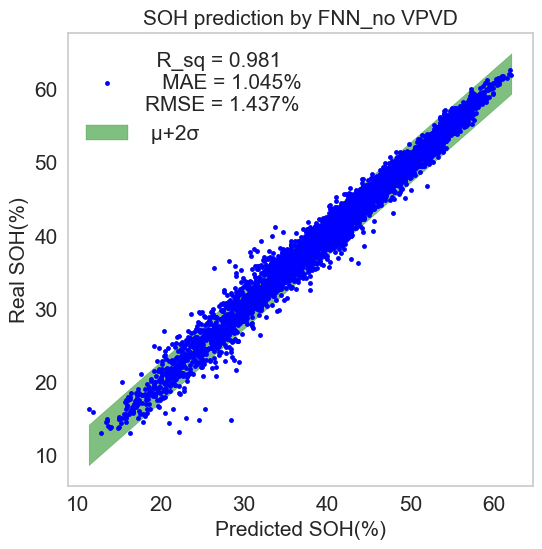

In [245]:
'''加信賴區間後的圖'''
import seaborn as sns
import matplotlib
import scipy.stats as st
matplotlib.rcParams.update({'font.size': 20})

# predicted expect and calculte confidence interval
low_ci_bound, high_ci_bound = st.t.interval(0.95, len(y_test_pred_array),
                                           loc=y_test_pred_array,scale=Residualss.std())   #st.sem(y_test_pred_array)
print("low_ci_bound\n", low_ci_bound)
print("high_ci_bound\n", high_ci_bound)
print("std of the SOH\n  = ", np.round(st.sem(y_test_pred_array),3))

# plot confidence interval
plt.figure(figsize=(6,6),dpi=100)   #, color='green', linestyle='dashed', linewidth = 3, marker='o',
plt.plot(y_test_pred_array, y_test_array, color='blue', linestyle='None' , marker='.', label=f'  R_sq = {R_sq}\n   MAE = {MAE}%\nRMSE = {RMSE}%')   #, 'b.'
plt.fill_between(sorted(y_test_pred_array), sorted(low_ci_bound), sorted(high_ci_bound), color='green', alpha=0.5,
                label=' μ+2σ')
plt.xlabel("Predicted SOH(%)", fontsize=15) 
plt.ylabel("Real SOH(%)", fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.title("SOH prediction by FNN_no VPVD", fontsize=15)   #_LOW LR_0
plt.grid()
plt.show()

Sampling Mean: -0.269
Sampling StdErr: 1.411
95% Confidence Interval: [-3.035  2.497]


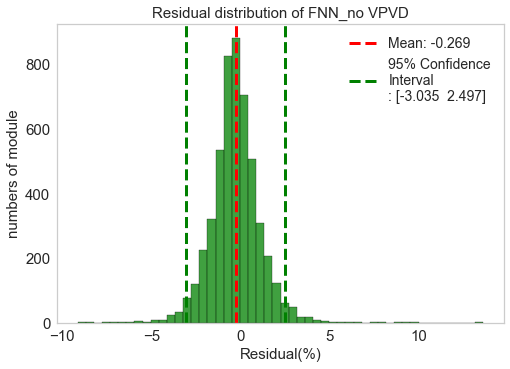

In [246]:
'''Residuals'''
from scipy import stats

Residualss = np.array(y_test_pred_array)-np.array(y_test_array)
# 取得 X_mean 的 mean, std, 95% 信賴區間
m = Residualss.mean()                  # X_bar 的平均
se = Residualss.std()                  # 標準誤
ci = np.round(stats.norm.interval(0.95, m, se),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m:.3f}')
print (f'Sampling StdErr: {se:.3f}')
print (f'95% Confidence Interval: {ci}')

sns.histplot(Residualss, color='green', bins=50, kde=False)
plt.axvline(m, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m:.3f}')
plt.axvline(ci[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci}')
plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Residual(%)', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Residual distribution of FNN_no VPVD', fontsize=15)   #_LOW LR_0
plt.legend(fontsize=14);
plt.grid();
plt.show()

Sampling Mean: -0.004
Sampling StdErr: 0.048
95% Confidence Interval: [-0.098  0.089]


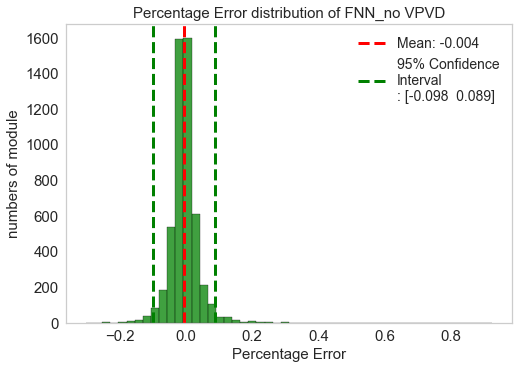

In [247]:
'''Percentage Error'''
pep_fnn = Residualss/y_test_array

# 取得 X_mean 的 mean, std, 95% 信賴區間
m3 = pep_fnn.mean()                  # X_bar 的平均
se3 = pep_fnn.std()                  # 標準誤
ci3 = np.round(stats.norm.interval(0.95, m3, se3),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m3:.3f}')
print (f'Sampling StdErr: {se3:.3f}')
print (f'95% Confidence Interval: {ci3}')

sns.histplot(pep_fnn, color='green', bins=50, kde=False)
plt.axvline(m3, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m3:.3f}')
plt.axvline(ci3[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci3}')
plt.axvline(ci3[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Percentage Error', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Percentage Error distribution of FNN_no VPVD', fontsize=15)   #_LOW LR_0
plt.legend(fontsize=14);
plt.grid();
plt.show()

# 叫出FNN.pickle預測soh

In [267]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot
import pickle

a = '改掉SOH定義的資料集_noerror.csv'
data = np.genfromtxt(a, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')
[Row,Column] = data.shape     #print(data[0:2,:])
## 新數據正規化:注意feature數! ##
scaler_i = pp.MinMaxScaler().fit(data[:,[1,2,3,4,5]])
data_var_i = scaler_i.transform(data[:,[1,2,3,4,5]])
data_soh_i = data[:,0:1]
data_all_i = np.hstack((data_soh_i, data_var_i))     # 製作 normalized features + raw SOH數據
print("data_all\n", data_all_i[0])
features_train3, features_test3, soh_train3, soh_test3 = train_test_split(data_all_i[:,[1,2,3,4,5]], data_all_i[:,0:1], test_size=0.2, random_state=100)
print("soh_train3\n", soh_test3)     #檢查格式是否正確,才不會讓ML程式垮掉；#print("features_train3\n", features_train3)
## 用原始數據當input ##
X_train3 = torch.from_numpy(features_train3.astype(np.float64))
y_train3 = torch.from_numpy(soh_train3.astype(np.float64))
X_test3 = torch.from_numpy(features_test3.astype(np.float64))
y_test3 = torch.from_numpy(soh_test3.astype(np.float64))
print("soh_train3\n", y_test3)       #檢查格式是否正確,才不會讓ML程式垮；#print("features_train3\n", X_train3)

data_all
 [59.916668    1.          0.8322884   0.55167532  0.07867325  0.56570997]
soh_train3
 [[30.583334]
 [31.666666]
 [44.11111 ]
 ...
 [23.416666]
 [52.555553]
 [41.25    ]]
soh_train3
 tensor([[30.5833],
        [31.6667],
        [44.1111],
        ...,
        [23.4167],
        [52.5556],
        [41.2500]], dtype=torch.float64)


In [278]:
## 用原始數據做輸入,會出現可怕且不實際的結果...訓練時做過正規化,那應用時就要對input做正規化 ##
with open(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0328檢驗feature影響力\FNN_06.pickle', 'rb') as f:
    model_fnn = pickle.load(f)
    pred=model_fnn(X_test3.float()).detach().numpy()
    print(pred)

[[31.342285]
 [33.622406]
 [45.433445]
 ...
 [22.881927]
 [52.304604]
 [41.976303]]


In [341]:
'''全部的訓練結果'''
R_sq = np.round(r2_score(pred, soh_test3),3)
MAE = np.round(mean_absolute_error(pred, soh_test3),3)
RMSE = np.round(np.sqrt(mean_squared_error(pred, soh_test3)),3)
Residualss = np.array(pred)-np.array(soh_test3)
print("loss\n", [R_sq, MAE, RMSE])
print("Residualss\n", Residualss)

loss
 [0.981, 1.045, 1.437]
Residualss
 [[ 0.75895116]
 [ 1.95574001]
 [ 1.32233498]
 ...
 [-0.53473851]
 [-0.25094942]
 [ 0.7263031 ]]


In [363]:
'''部分的訓練結果: 找出soh大於50(%)的模組,觀察其loss值'''
screened = [sc for sc,val in enumerate(pred) if val < 3200/60]
pred_pick = np.delete(pred[:], screened).astype(np.float32);
soh_test3_pick = np.delete(soh_test3[:], screened).astype(np.float32);

R_sq_p = np.round(r2_score(pred_pick, soh_test3_pick),3)
MAE_p = np.round(mean_absolute_error(pred_pick, soh_test3_pick),3)
RMSE_p = np.round(np.sqrt(mean_squared_error(pred_pick, soh_test3_pick)),3)
Residualss_p = np.array(pred_pick)-np.array(soh_test3_pick)
print("loss\n", [R_sq_p, MAE_p, RMSE_p])
print("Residualss\n", Residualss_p)
print("member\n", len(pred_pick))

loss
 [0.788, 0.649, 0.833]
Residualss
 [ 9.81437683e-01 -6.92562103e-01  4.70893860e-01  4.17140961e-01
 -4.67182159e-01  1.07685089e-01 -6.58550262e-01 -3.79398346e-01
 -4.13208008e-01 -7.95223236e-01 -1.89121246e-01 -3.82675171e-01
  6.79687500e-01  2.37148285e-01 -1.69784546e+00 -6.34105682e-01
 -8.19744110e-01 -4.83932495e-02 -6.46755219e-01 -2.81009674e+00
 -2.34588623e-01 -6.47190094e-01 -7.49370575e-01 -2.10398483e+00
  2.60379791e-01 -6.66759491e-01  8.75137329e-01 -6.04484558e-01
 -1.62971115e+00 -1.12628174e+00 -4.69715118e-01  5.29098511e-03
 -3.01761627e-01  3.40427399e-01 -4.53071594e-02 -7.79991150e-01
 -2.69428253e-01 -4.43679810e-01 -6.12289429e-01 -5.48095703e-01
 -2.71705627e-01 -2.99209595e-01 -7.03842163e-01  1.02494812e+00
 -1.18785858e-01 -3.20659637e-01 -1.13651276e-01 -4.34295654e-01
 -1.06130981e+00  5.47069550e-01  3.44913483e-01 -2.79769897e-01
 -1.87488556e-01 -8.42185974e-01 -8.28159332e-01  9.26971436e-03
 -6.87248230e-01 -8.85005951e-01 -3.39229584e-01 -

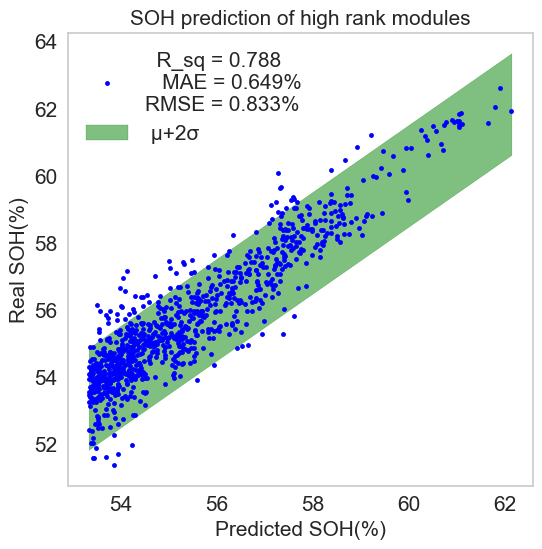

In [364]:
matplotlib.rcParams.update({'font.size': 15})
low_ci_bound_p, high_ci_bound_p = st.t.interval(0.95, len(pred_pick),
                                           loc=pred_pick,scale=Residualss_p.std())

plt.figure(figsize=(6,6),dpi=100)
plt.plot(pred_pick, soh_test3_pick, color='blue', linestyle='None' , marker='.',
         label=f'  R_sq = {R_sq_p}\n   MAE = {str(MAE_p)}%\nRMSE = {str(RMSE_p)}%')
plt.fill_between(sorted(pred_pick), sorted(low_ci_bound_p), sorted(high_ci_bound_p),
                 color='green', alpha=0.5, label=' μ+2σ')
plt.tick_params(labelsize=15)
plt.xlabel("Predicted SOH(%)", fontsize=15) #15
plt.ylabel("Real SOH(%)", fontsize=15)
plt.legend(fontsize=15)
plt.title("SOH prediction of high rank modules", fontsize=15)   #_No relaxation
plt.grid()
plt.show()

# 應用accuracy衡量效果

In [365]:
'''自己的例子'''   #pred, soh_test3[0]；pred_pick, soh_test3_pick
fiftyup = np.asarray([pred_pick, soh_test3_pick]).T
print("fiftyup\n", fiftyup)
print("fiftyup[pred]\n", fiftyup[:,0])
print("fiftyup_size\n", len(fiftyup))

fiftyup
 [[56.259216 55.27778 ]
 [54.335217 55.02778 ]
 [55.88756  55.416668]
 ...
 [53.81973  54.5     ]
 [56.65712  54.944447]
 [55.925373 55.13889 ]]
fiftyup[pred]
 [56.259216 54.335217 55.88756  57.139362 54.89393  55.302128 54.56367
 56.81505  53.947903 54.482555 53.977543 55.450657 55.846355 56.82048
 55.941044 54.81034  54.235813 55.396053 54.242134 57.273235 54.1543
 53.408363 57.36174  54.007126 53.62149  54.249905 53.45847  61.034405
 54.286957 53.901497 59.58584  56.838627 55.226017 55.701538 54.315804
 61.08112  53.452793 56.94521  53.38771  54.646347 54.811626 55.58968
 56.712826 56.60828  55.353436 54.70712  53.441906 54.787926 56.68869
 56.79707  57.983803 55.85912  58.173622 53.574482 54.005173 55.62038
 54.396084 53.614994 53.66077  55.517048 54.42219  57.74988  54.557568
 54.512814 55.56164  56.2195   58.79818  57.067608 55.686012 53.610577
 57.17415  57.241375 54.905075 53.690403 53.91247  53.77879  57.56088
 53.64344  56.36591  53.69683  53.96666  53.407272 55.06032

In [366]:
kpoweh = np.empty((len(fiftyup),2), dtype = object);
for i in range(2):
    for j in range(len(fiftyup)):
        if fiftyup[j,i] > 53 or fiftyup[j,i] >53:
            kpoweh[j,i] = 1
        else:
            kpoweh[j,i] = 0

print("kpoweh\n", kpoweh)

kpoweh
 [[1 1]
 [1 1]
 [1 1]
 ...
 [1 1]
 [1 1]
 [1 1]]


In [367]:
n_tp_tn = (kpoweh[:,0]==kpoweh[:,1]).sum()
print("n_tp_tn\n",n_tp_tn)
acc = np.round(n_tp_tn/len(kpoweh), 3)
print(acc)

n_tp_tn
 922
0.965


In [ ]:
--------------------------------------------------------------------------------------------------------------------------------

In [302]:
'''網路上的範例'''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

titanic = pd.read_csv('https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv')
subset = titanic[['Sex', 'Age', 'Pclass']]
median_imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
age_imputed = median_imputer.fit_transform(subset['Age'].values.reshape(-1, 1))
subset = subset.assign(Age = age_imputed)
X = subset.values
y = titanic['Survived'].values
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.33, random_state = 42)

def expert_opinion(X):
    if X[0] == 'female' or X[1] < 12 or X[2] == 1:
        return 1
    else:
        return 0

In [322]:
y_pred = np.zeros(y_validation.size, dtype = int)
for i in range(X_validation.shape[0]):
    y_pred[i] = expert_opinion(X_validation[i])

In [323]:
y_pred[:]

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0])

In [324]:
y_validation[:]

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0], dtype=int64)

In [325]:
n_tp_tn = (y_pred==y_validation).sum()
print("n_tp_tn\n",n_tp_tn)
acc = np.round(n_tp_tn/y_validation.size, 3)
print(acc)

n_tp_tn
 231
0.783


# 做到這裡就好

In [129]:
print("ord of pep_fnn(des) = \n", sorted(pep_fnn, reverse=True)[0:10])
print("ord of pep_fnn(asc) = \n", sorted(pep_fnn)[0:10])

max of pep_fnn =  0.7413804676786462
ord of pep_fnn(des) = 
 [0.7413804676786462, 0.42345050307420323, 0.36851151067942983, 0.3594402356968568, 0.31711492627108523, 0.309194667604928, 0.30464619355899525, 0.2546744672496839, 0.2377729311094179, 0.23493408170503893]
ord of pep_fnn(asc) = 
 [-0.2598161925959211, -0.2464954077286134, -0.2219220665975718, -0.20280947071810104, -0.20062454581065853, -0.19878337403804747, -0.18662337089519979, -0.18269738257385879, -0.1761117052266135, -0.17583499942009592]


In [100]:
file_FNN = np.asarray([y_test_array,y_test_pred_array,Residualss]).T
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0327改soh後ML模型&結果\3_FNN預測結果_0.03.csv',file_FNN,fmt='%s',delimiter=',')
print("FNN", file_FNN)   #_fixed seed_6_no VPVD

FNN [[30.583334   31.23758888  0.65425488]
 [31.666666   33.6528511   1.9861851 ]
 [44.11111    46.01766205  1.90655205]
 ...
 [23.416666   22.80419922 -0.61246678]
 [52.555553   52.76747894  0.21192594]
 [41.25       43.36035538  2.11035538]]


In [168]:
file_FNN = np.asarray([y_test_array,y_test_pred_array,Residualss]).T
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0327改soh後ML模型&結果\3_FNN預測結果_No relaxation time.csv',file_FNN,fmt='%s',delimiter=',')
print("FNN", file_FNN)

FNN [[52.5        52.67398453  0.17398453]
 [54.3        56.15620422  1.85620422]
 [75.6        78.30753326  2.70753326]
 ...
 [40.1        38.56296158 -1.53703842]
 [90.1        89.98116302 -0.11883698]
 [85.1        87.96678162  2.86678162]]


In [ ]:
# 做到這裡就好

In [211]:
'''省時間,從既有檔案抓數據'''

a = r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\3_FNN預測結果.CSV'
data = np.genfromtxt(a, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')
[Row,Column] = data.shape
print(data[0:2,:])
y_test_array = data[:,0]
y_test_pred_array = data[:,1]
Residualss = data[:,2]
#R_sq = np.round(model.fit(features_train2, soh_train2).score(features_test2, soh_test2),3)
MAE = np.round(mean_absolute_error(y_test_pred_array,y_test_array),3)
RMSE = np.round(np.sqrt(mean_squared_error(y_test_pred_array,y_test_array)),3)

[[52.5        52.70244217  0.20244217]
 [54.3        56.57046509  2.27046509]]


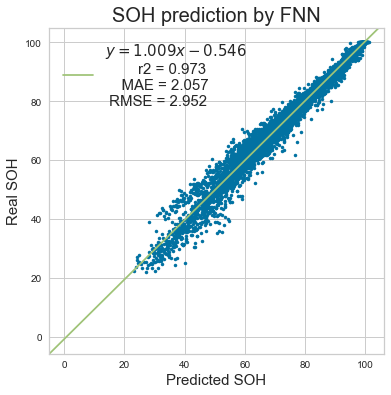

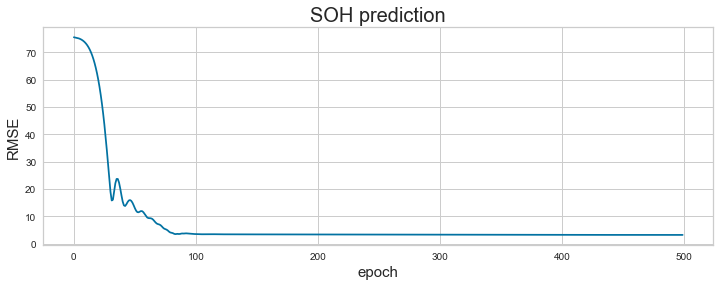

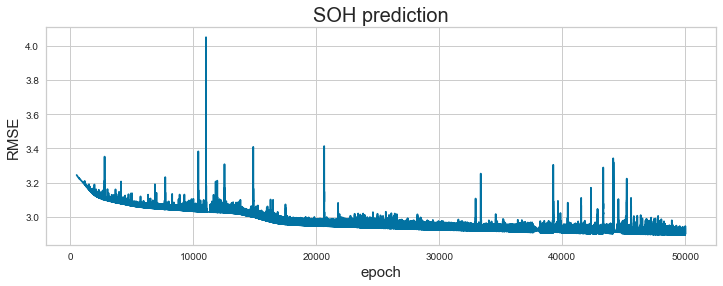

time elapsed:2570.0 seconds
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20 ;; learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  2.903
Result_test  =  2.952
r2 score =  0.973


In [162]:
plt.figure(figsize=(6,6))
plt.plot(y_test_pred_array, y_test_array, 'b.');     #
m1, b1 = np.polyfit(y_test_pred_array, y_test_array, 1);
plt.axline(xy1=(0, b1), slope=m1, color='g', label=f'$y = {m1:.3f}x {b1:+.3f}$\n        r2 = {R_sq}\n    MAE = {MAE}\n RMSE = {loss_test:.3f}') # 
# plt.xlim(25000, 35000)
# plt.ylim(0, 40000)
plt.xlabel("Predicted SOH", fontsize=15)
plt.ylabel("Real SOH", fontsize=15)
plt.title("SOH prediction by FNN", fontsize=20);
plt.legend(fontsize=15)
plt.savefig("SOH prediction by FNN" + ".jpg"); plt.show();  #save as jpg
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,500,1),eveloss[0:500]);     # ,'ro'
plt.xlabel("epoch", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.title("SOH prediction", fontsize=20);
plt.savefig("loss of SOH prediction(early)" + ".jpg"); plt.show();     #save as jpg
plt.figure(figsize=(12,4))
plt.plot(np.arange(499,50000,1),eveloss[499:50000]);     # ,'ro'
plt.xlabel("epoch", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.title("SOH prediction", fontsize=20);
plt.savefig("loss of SOH prediction(late)" + ".jpg"); plt.show();     #save as jpg'''

print("time elapsed:" + str(np.round(t2-t1,3)) + " seconds")
print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ' ;; ' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ' hidden_4= ' + f"{H4}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("Result_train = ", np.round(np.mean(totalerr_train),3))
print("Result_test  = ", np.round(np.mean(totalerr_test),3));
print("r2 score = ", np.round(np.mean(total_corr),3));

C:\Users\Chun-Po\miniconda3\envs\env_pytorch\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'SOH prediction by FNN (with confidence interval)')

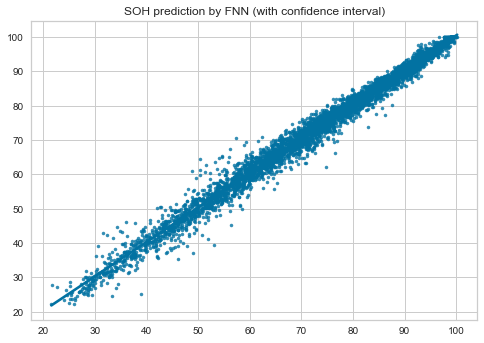

In [117]:
import seaborn as sns

ax = sns.regplot(y_test_pred_array, y_test_array, marker='.')
ax.set_title('SOH prediction by FNN (with confidence interval)')

# 紀錄FNN成果

In [ ]:
1229.0953(填紀錄時間)
time elapsed:2635.61 seconds
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20 ;; learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  2.058
Result_test  =  2.175
r2 score =  0.986

1228.2149(填紀錄時間)
time elapsed:2467.719 seconds
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20 ;; learning_rate = 0.005, lambda_l2 = 5e-05
Result_train =  2.464
Result_test  =  2.402
r2 score =  0.982

1228.2015(填紀錄時間)
time elapsed:2631.062 seconds
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20 ;; learning_rate = 0.03, lambda_l2 = 5e-05
Result_train =  2.115
Result_test  =  2.225
r2 score =  0.985

1228.1924(填紀錄時間)
time elapsed:2320.265 seconds
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20 ;; learning_rate = 0.02, lambda_l2 = 5e-05
Result_train =  2.114
Result_test  =  2.209
r2 score =  0.985

1228.1753(填紀錄時間)
time elapsed:2493.359 seconds
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  2.109
Result_test  =  2.232
r2 score =  0.984

In [15]:
numer = np.empty((27064,7), dtype = object);
for i in range(27064):
    for j in range(7):
        strin = str(data[i,j])
        value = strin.replace('nan','0')
        numer[i,j] = float(value)
err_rex = [w1 for w1,x1 in enumerate(numer[:,2]) if x1>0]     # 刪掉relaxation>0
err_inf = [w2 for w2,x2 in enumerate(numer[:,3]) if x2==2500]     # 刪掉inflection==2500
err_v15 = [w3 for w3,x3 in enumerate(numer[:,4]) if x3==0]     # 刪掉V15無數據(nan)或數據=0的.astype(np.float32)
err = sorted(set(err_rex+err_inf+err_v15))
data_new = np.delete(numer[:,:], (err),axis=0);
#SOH_part_ok = np.delete(SOH_part[:], err).astype(np.float32);.astype(np.float32)
#number = np.delete(numer[:,:], (err),axis=0);     # length_numer 27064; length_number 18631
print(data_new)
print(len(data_new))
print(type(data_new))

[[100.0 4.008333264 -0.233 ... 8.0069 1500.0 8.75]
 [100.0 4.008333264 -0.214 ... 7.9929 1710.0 8.67]
 [100.0 4.008333264 -0.233 ... 8.0034 1570.0 8.73]
 ...
 [68.2 2.773333368 -0.291 ... 8.3629 940.0 8.84]
 [83.1 3.414305544 -0.267 ... 8.1095 1280.0 8.77]
 [92.1 3.836805492 -0.225 ... 8.1248 1350.0 8.73]]
25548
<class 'numpy.ndarray'>


In [16]:
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\新特徵資料_noerror.csv',data_new,delimiter=',')
print(type(data_new))

<class 'numpy.ndarray'>


In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

a = 'ML_ift+relax+796.csv'     # usecols=np.arange(0,4),
#err_Chrtime = [119, 934, 1062, 1341, 1354, 1467, 1858, 2097, 2220, 2227, 2243, 2479, 3376, 3484, 3485, 3750, 4294, 4375, 4383, 4873, 5324, 5766, 6918, 6935, 7119, 7611, 8363, 8955, 9120, 9515, 10055, 10083, 10177, 10191, 10342, 10390, 11527, 12168, 12849, 13317, 13557, 13853, 14121, 14222, 14618, 16676, 17079, 18105, 18193, 18584, 18626, 18814, 19038, 19107, 19287, 19527, 19663, 19669, 20254, 20742, 21440, 21614, 21719, 21804, 21961, 21963, 23175, 23348, 23948, 24152, 24388, 24397, 24410, 25981, 26001]
data = np.genfromtxt(a, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')
[Row,Column] = data.shape
print(data[:,[3,0,4,5,6,7,8]])

[[ 1.00000000e+02  4.00833326e+00 -2.33000000e-01 ...  8.00690000e+00
   1.50000000e+03  8.75000000e+00]
 [ 1.00000000e+02  4.00833326e+00 -2.14000000e-01 ...  7.99290000e+00
   1.71000000e+03  8.67000000e+00]
 [ 1.00000000e+02  4.00833326e+00 -2.33000000e-01 ...  8.00340000e+00
   1.57000000e+03  8.73000000e+00]
 ...
 [ 6.82000000e+01  2.77333337e+00 -2.91000000e-01 ...  8.36290000e+00
   9.40000000e+02  8.84000000e+00]
 [ 8.31000000e+01  3.41430554e+00 -2.67000000e-01 ...  8.10950000e+00
   1.28000000e+03  8.77000000e+00]
 [ 9.21000000e+01  3.83680549e+00 -2.25000000e-01 ...  8.12480000e+00
   1.35000000e+03  8.73000000e+00]]


In [4]:
file = data[:,[3,0,4,5,6,7,8]]
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\新特徵資料.csv',file,delimiter=',')
print("newfeatures", file[0,:])

newfeatures [ 1.00000000e+02  4.00833326e+00 -2.33000000e-01  1.17000000e+03
  8.00690000e+00  1.50000000e+03  8.75000000e+00]
